# DSCI 100 Section 009 Group 8 Project Final Report

## Introduction
### Background Information
The UEFA Champions League is one of the most presitigous and widely followed club football competitions. The competition brings elite football clubs from across Europe together in competition.The data we chose to analyze is about game statistics. We are using the keystats.csv dataset. Our data set contains serial number, player name, club name, position, and various game statistics such as distance traveled on the field, number of goals, tackles attempted, etc. Our goal is to use the game statistics like number of goals and distance traveled on the field to predict the positions of the players.

### Questions
Predict the position of the player that participated in UEFA Champions League 2021-2022 based on the statistics that we have, such as goals, distance covered, etc.

### Dataset Description
The dataset source is the UEFA player statistics for every player in the UEFA Champions League in the 2021-2022 season scraped by Azmine Toushik Wasi from the UEFA website.

## Preliminary Exploratory Data Analysis
### Reading the Data
First of all, the data has been pushed to our group's github repository. Therefore, we can use the read_csv function to read all the data we need (our data is separated into several files). First of all, we need to initialize the libraries we are going to use

In [56]:
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
library(GGally)
options(repr.matrix.max.rows = 6)

The dataset we will use are the key stats, defending, and distribution dataset. We will read them using the read_csv function

In [4]:
key_stats <- read_csv("https://raw.githubusercontent.com/JoelGunawan/dsci-100-009-group-8/main/data/key_stats.csv")
defending <- read_csv("https://raw.githubusercontent.com/JoelGunawan/dsci-100-009-group-8/main/data/defending.csv")
distribution <- read_csv("https://raw.githubusercontent.com/JoelGunawan/dsci-100-009-group-8/main/data/distributon.csv")

Rows: 747 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (4): player_name, club, position, distance_covered
dbl (4): minutes_played, match_played, goals, assists

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 627 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (4): serial, player_name, club, position
dbl (6): balls_recoverd, tackles, t_won, t_lost, clearance_attempted, match_...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 608 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (4): serial, player_name, club, position
dbl (8): pass_accuracy, pass_attempted, pass_completed, cr

### Cleaning and Wrangling
The data we have is separated into several different datasets, therefore we will merge the dataset together using the merge function, which will merge two different data frames based on a certain property

In [5]:
football <- merge(key_stats, defending, by = "player_name") |>
    merge(distribution, by = "player_name")
football

player_name,club.x,position.x,minutes_played,match_played.x,goals,assists,distance_covered,serial.x,club.y,...,club,position,pass_accuracy,pass_attempted,pass_completed,cross_accuracy,cross_attempted,cross_complted,freekicks_taken,match_played
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<U+00C1>lvarez,Ajax,Midfielder,558,7,0,0,73,121,Ajax,...,Ajax,Midfielder,93.3,363,340,0,1,0,7,7
<U+00C9>der Milit<U+00E3>o,Real Madrid,Defender,1076,12,0,0,110.4,01,Real Madrid,...,Real Madrid,Defender,87.5,643,563,0,2,0,17,12
<U+00D3>liver Torres,Sevilla,Midfielder,168,4,0,0,25.8,479,Sevilla,...,Sevilla,Midfielder,79.5,122,105,20,5,1,2,4
...,...,...,...,...,...,...,...,...,...,,...,...,...,...,...,...,...,...,...,...
Zeki <U+00C7>elik,LOSC,Defender,591,7,0,1,71.3,121,LOSC,...,LOSC,Defender,78.0,297,233,33,12,4,9,7
Zinchenko,Man. City,Defender,501,8,0,1,64.4,102,Man. City,...,Man. City,Defender,88.0,356,314,23,13,3,4,8
Ziyech,Chelsea,Midfielder,446,9,1,2,53.5,317,Chelsea,...,Chelsea,Midfielder,76.8,240,186,26,41,11,3,9


We will wrangle the data in several ways before we can use it. First of all, we will change the position to a factor because it is a categorical value. After that, the distance covered initially given is stored in a character value, but we need it as a numeric. Therefore, we will convert it to a numeric column. After that, we will remove all goalkeepers from our model, because the position of goalkeeper is concrete and predicting which players are goalkeepers are not of relevance to anyone because they are so distinct. Finally, we will select the columns we want to use

In [6]:
football_data <- football |>
    mutate(position = as_factor(position)) |>
    mutate(distance_covered = as.numeric(distance_covered)) |>
    filter(position != "Goalkeeper") |>
    select(position, goals, distance_covered, pass_attempted, tackles, clearance_attempted)
football_data

position,goals,distance_covered,pass_attempted,tackles,clearance_attempted
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Midfielder,0,73.0,363,19,7
Defender,0,110.4,643,19,32
Midfielder,0,25.8,122,0,0
...,...,...,...,...,...
Defender,0,71.3,297,8,8
Defender,0,64.4,356,6,8
Midfielder,1,53.5,240,5,1


We will split the data into training and testing datasets

In [7]:
# Set seed so the workflow is reproducible
set.seed(5000)
football_split <- initial_split(football_data, prop = 0.75, strata = position)
football_train <- training(football_split)
football_test <- testing(football_split)
football_train

position,goals,distance_covered,pass_attempted,tackles,clearance_attempted
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Defender,0,110.4,643,19,32
Defender,0,46.3,225,6,24
Defender,1,36.9,259,3,19
...,...,...,...,...,...
Midfielder,1,59.1,295,8,6
Midfielder,0,24.3,66,5,3
Midfielder,0,54.1,218,8,4


### Data Summary
First, let us look at the amount of players in each position

In [8]:
pos_count <- football_train |>
    group_by(position) |>
    summarize(amount = n())
pos_count

position,amount
<fct>,<int>
Midfielder,189
Defender,178
Forward,92


We will check how many NA values are in our dataset

In [9]:
na_data <- football_train |> 
    group_by(position) |>
    summarize(cntna = sum(is.na(goals:clearance_attempted)))
na_data

Warning message:
"There were 3 warnings in `summarize()`.
The first warning was:
i In argument: `cntna = sum(is.na(goals:clearance_attempted))`.
i In group 1: `position = Midfielder`.
Caused by warning in `goals:clearance_attempted`:
! numerical expression has 189 elements: only the first used
i Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings."


position,cntna
<fct>,<int>
Midfielder,0
Defender,0
Forward,0


We do not have any NA data because the NA data has been removed when we were merging the dataset previously

### Data Visualization
First, we will try to visualize one of the two predictor variables we will use, which are the clearances attempted and tackles. We will visualize the data in a scatter plot

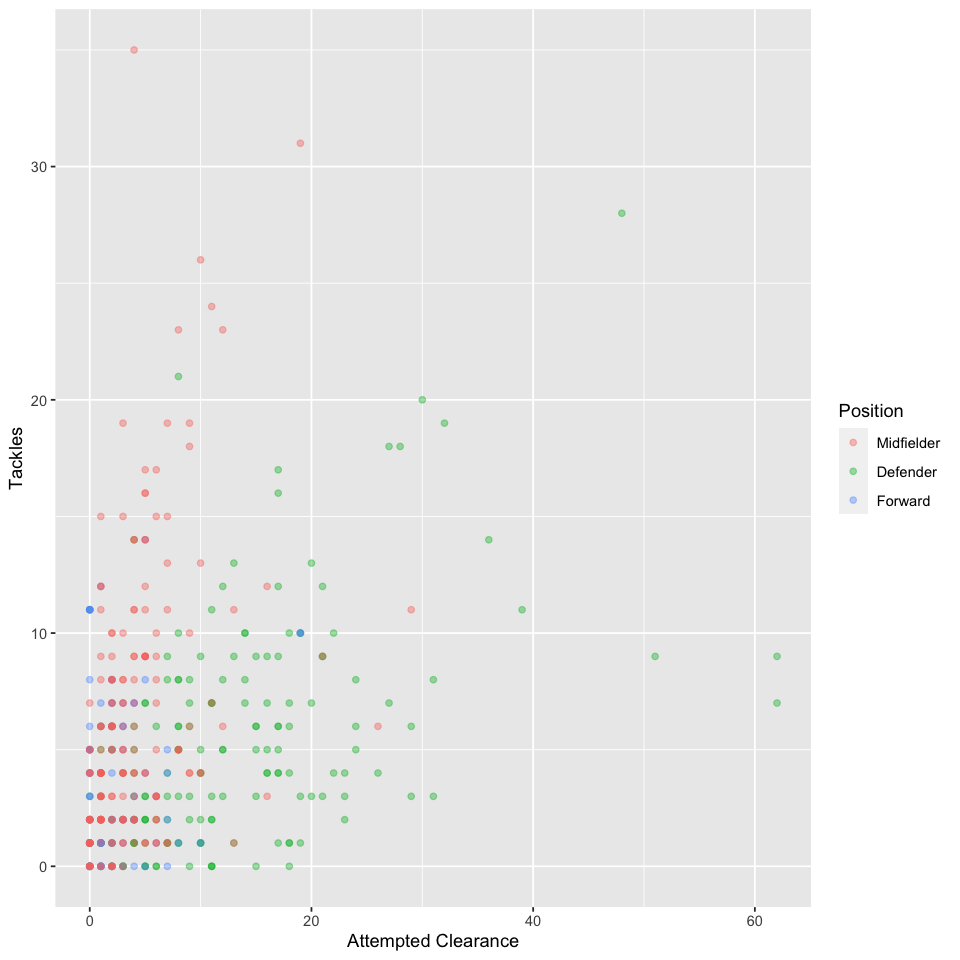

In [72]:
options(repr.plot.width = 8, repr.plot.height = 8)
football_plot <- football_train |>
    ggplot(aes(x = clearance_attempted, y = tackles, color = position)) +
    geom_point(alpha = 0.4) +
    labs(x = "Attempted Clearance", y = "Tackles", color = "Position")
football_plot

As the visualization demonstrates, most defenders have high numbers of attempted clearances (the bottom right of the graph). In addition, most midfielders have a high number of tackles (the top left of the graph).

We will visualize all pairs of the columns we chose

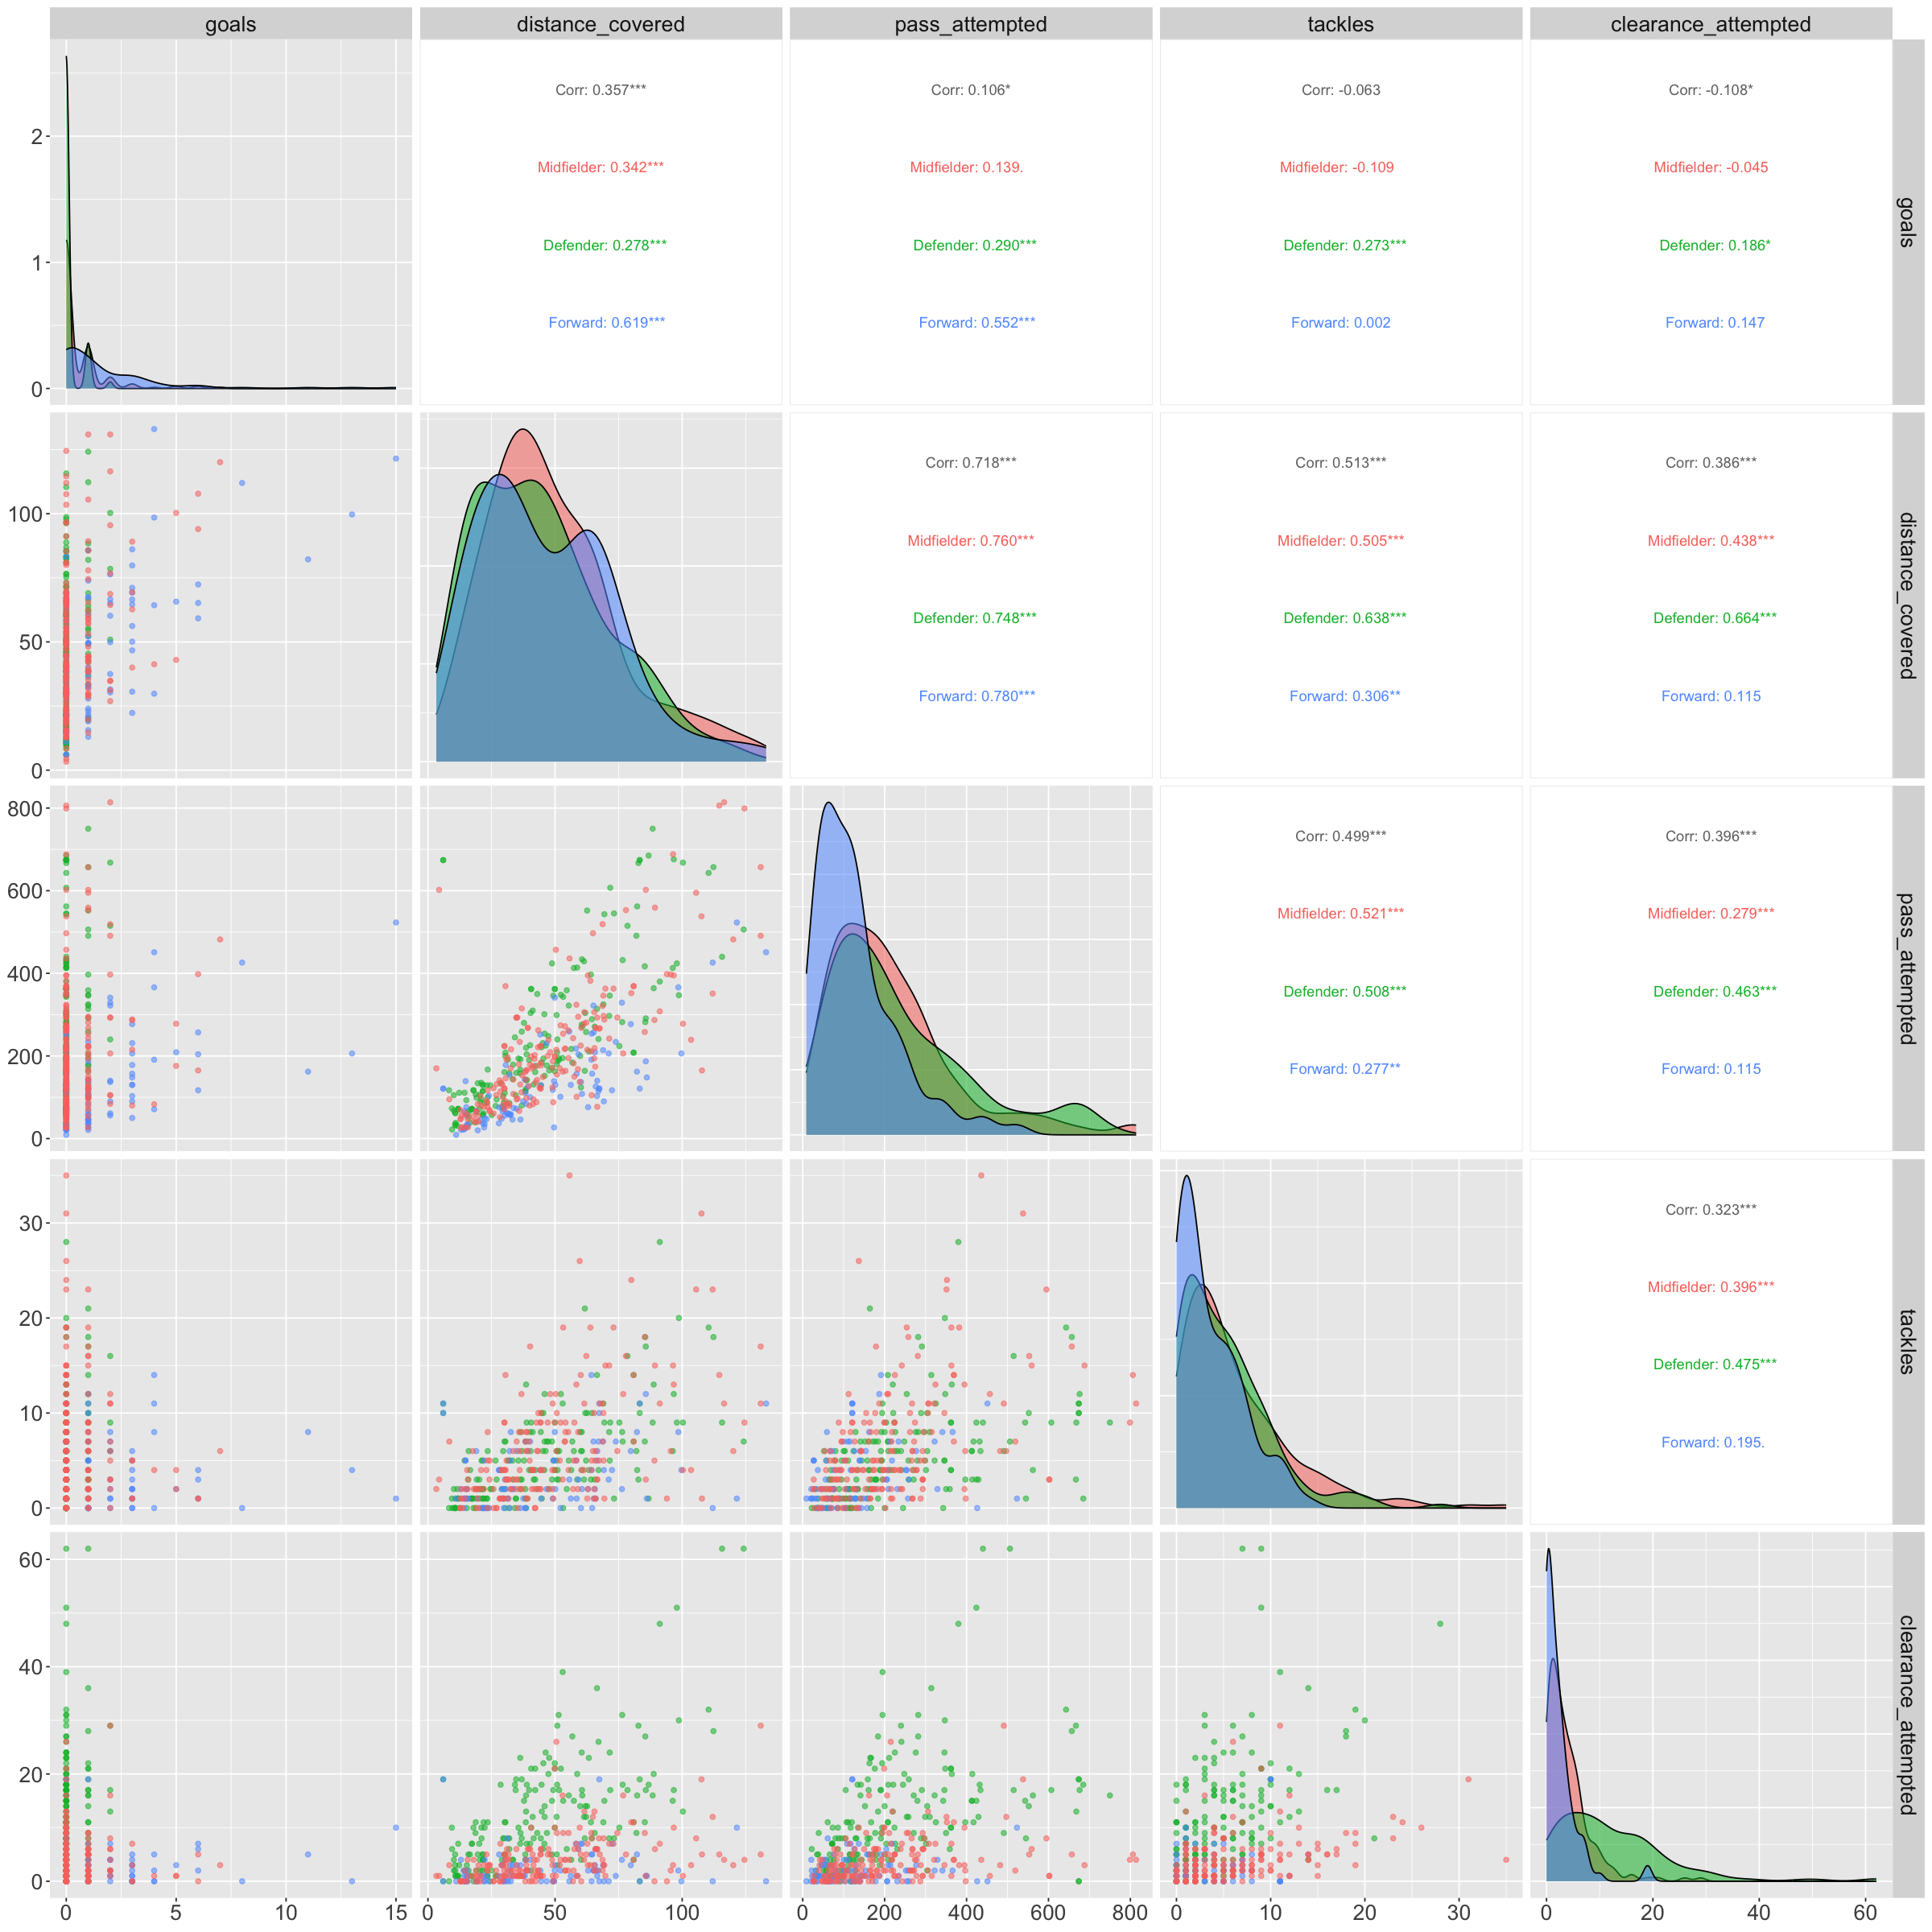

In [67]:
options(repr.plot.width = 20, repr.plot.height = 20)
pairs_plot <- ggpairs(football_train, columns = 2:ncol(football_train), aes(color = position, alpha = 0.2)) + 
    theme(text = element_text(size = 20))

pairs_plot

### Data Analysis

We are going to perform the data analysis using the KNN algorithm. In this analysis, we will try K values from 2 to 30 with step of 1 to find the optimal K value.

The following is the code for finding the optimal K value of the KNN.

In [73]:
set.seed(5000)
training_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_recipe <- recipe(position ~ ., data = football_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

training_vfold <- vfold_cv(data = football_train, v = 10, strata = position)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

training_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(training_spec) |>
    tune_grid(resamples = training_vfold, grid = k_vals)

training_metrics <- training_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

training_metrics

> A | warning: No observations were detected in `truth` for level(s): 'Goalkeeper'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x4

There were issues with some computations   A: x7

There were issues with some computations   A: x10





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6335746,10,0.01895652,Preprocessor1_Model01
2,accuracy,multiclass,0.6335746,10,0.01895652,Preprocessor1_Model02
3,accuracy,multiclass,0.6823801,10,0.02509471,Preprocessor1_Model03
...,...,...,...,...,...,...
48,accuracy,multiclass,0.6511823,10,0.02194116,Preprocessor1_Model48
49,accuracy,multiclass,0.6533100,10,0.02043824,Preprocessor1_Model49
50,accuracy,multiclass,0.6534088,10,0.01935942,Preprocessor1_Model50


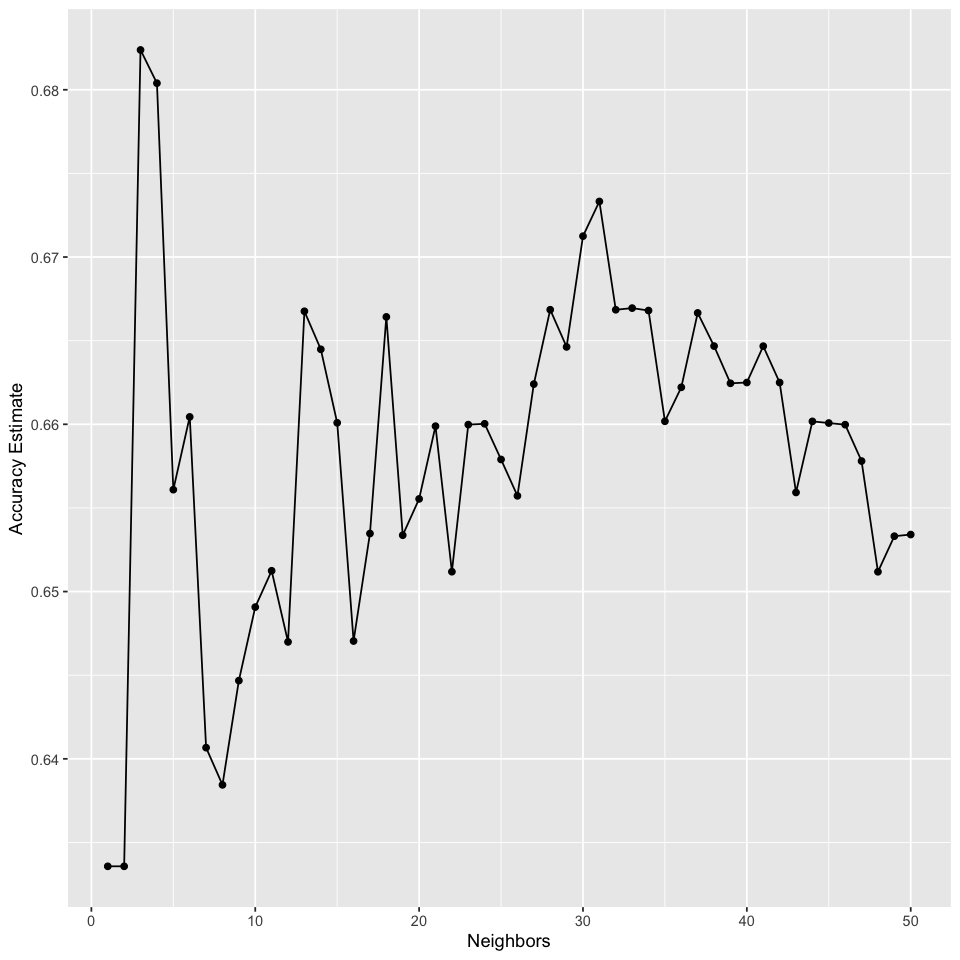

In [74]:
options(repr.plot.width = 8, repr.plot.height = 8)
accuracy_plot <- ggplot(training_metrics, aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_plot

As we can see, the maximum accuracy is when K = 3. As a result, we will pick K = 4 because it is a larger value and it is more stable (because K = 3 might be so small that a slight change in value might produce a large change in the result). The following is the code for the final model.

In [78]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>   
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = football_train)

knn_fit

== Workflow [trained] ==========================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor ----------------------------------------------------------------
2 Recipe Steps

* step_scale()
* step_center()

-- Model -----------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3572985
Best kernel: rectangular
Best k: 4

## Methods
### Variables and Columns Used
We will take the data and select the columns that are relevant to our prediction. In this case we choose goals, distance covered, passes attempted, tackles, and attempted clearances. We chose these variables because they or some combination of variables would typically be different based on the position. Offensive players score higher number of goals. Defenders and midfielders tend to have higher passes attempted. The most tackles come from offensive players pressing the opposition and defenders in defense. Finally, nearly all attempted clearances are done by defenders.

### Result Visualization Methods
We will visualize our training results using a line graph representing the accuracy of our predictions across several values. For the testing results, we can simply use the accuracy to measure our results. This is because we do not have a particular category of interest

## Expected outcomes and significance

###  Expected Findings 
The goal of the analysis is to predict the position of players who participated in the UEFA Champions League 2021-2022 based on their performance metrics: specifically, their goals scored and distance covered on the field. We anticipate finding patterns and relationships in the data that allow us to classify players into different positions using a K-Nearest Neighbors (KNN) classification model.

### Impact of Findings
Such findings can have several significant impacts. Firstly, they can provide insights into the key performance indicators for different player positions, aiding coaches and scouts in player recruitment and tactical strategies. Secondly, it can assist in the development of more accurate and data-driven player profiles for fans, analysts, and fantasy football enthusiasts. Lastly, it may contribute to enhancing the overall understanding of player roles and their relationships to performance metrics, potentially influencing player development and training methodologies.

### Future Questions
These findings may lead to several future questions and areas of research. For instance, it could prompt inquiries into how different factors, such as player age, playing style, or team tactics influence the relationships between goals scored, distance covered, and player position. It could also lead to more sophisticated machine learning models that incorporate additional performance metrics for even more accurate position classification. Furthermore, this analysis could open up discussions on the evolving nature of player positions in modern football and how they are defined in the context of data-driven insights.